In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style

style.use('dark_background')
import matplotlib.animation as animation
from matplotlib.ticker import LogFormatterSciNotation
from PIL import Image

FileNotFoundError: [Errno 2] No such file or directory: '7.3_graphs/photon_energy_boost_vs_gamma.png'

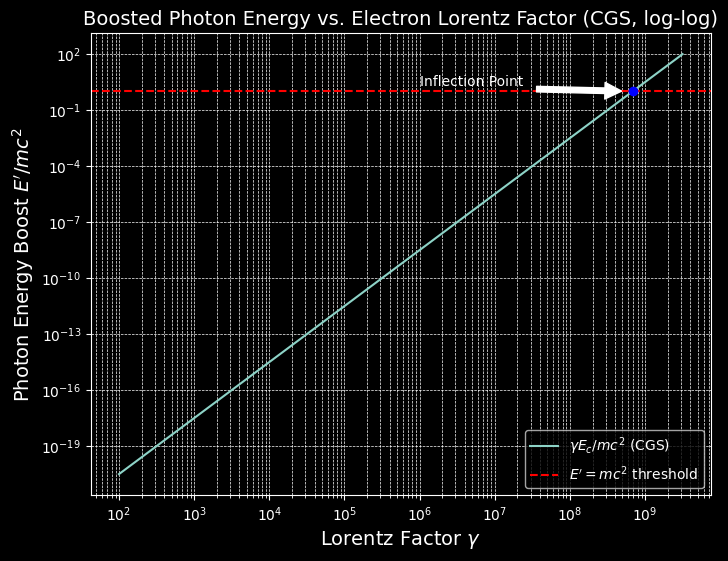

In [8]:
#solved the problem, but lets look how the solution varies as gamma changes

#constants in CGS
h = 6.63e-27  #plank (erg·s)
q = 4.8e-10   #elem. charge (statC)
m = 9.11e-28  #e- mass(g)
c = 3e10      #speed of light (cm/s)
B = 0.1       #mag field strength (G) (0.1G)
sin_alpha = 1 / np.sqrt(3)  # Average pitch angle assumption

#compute E_c (which is synch. photon energy in lab frame)
def compute_Ec_cgs(gamma, B_field):
    return (3/2) * (h * q * B_field / (2 * np.pi * m * c)) * gamma**2 * sin_alpha

#E'/mc**2 ratio
def compute_ratio_cgs(gamma, B_field):
    Ec = compute_Ec_cgs(gamma, B_field)
    mc2 = 0.511e6  #e- rest energy in eV
    return (gamma * Ec) / mc2

#np range of lorentz factors
gamma_values = np.logspace(2, 9.5, 10000) #probably too many points, but all gucci
ratios = compute_ratio_cgs(gamma_values, B)

#find crossing point
crossing_gamma = np.interp(1, ratios, gamma_values)

#lin looked bad, plot in loglog scale
plt.figure(figsize=(8, 6))
plt.loglog(gamma_values, ratios, label=r'$\gamma E_c / mc^2$ (CGS)')
plt.axhline(1, color='red', linestyle='--', label=r'$E^\prime = mc^2$ threshold')

plt.xlabel(r'Lorentz Factor $\gamma$', fontsize=14)
plt.ylabel(r'Photon Energy Boost $E^\prime / mc^2$', fontsize=14)
plt.title(r'Boosted Photon Energy vs. Electron Lorentz Factor (CGS, log-log)', fontsize=14)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.scatter(crossing_gamma, 1, color='blue', zorder=5)  # Mark the crossing point
#call out inflection point
plt.annotate('Inflection Point', xy=(crossing_gamma, 1), xytext=(1e6, 2),
             arrowprops=dict(facecolor='white', shrink=0.1))
plt.savefig('7.3_graphs/photon_energy_boost_vs_gamma.png', dpi=600)
plt.show()

In [ ]:
#follow this up with subplot of varying B, we will go from 0.01G to 1e9G or so
#gen subplots different strengths
def plot_boosted_energy_vs_gamma_varying_B(gamma_values, B_values):
    fig, axes = plt.subplots(1, len(B_values), figsize=(5 * len(B_values), 5), sharey=True)

    for i, B in enumerate(B_values):
        ratios = compute_ratio_cgs(gamma_values, B)
        crossing_gamma = np.interp(1, ratios, gamma_values)

        axes[i].loglog(gamma_values, ratios, label=rf'$B = {B}$ G')
        axes[i].axhline(1, color='red', linestyle='--', label=r'$E^\prime = mc^2$ threshold')
        axes[i].scatter(crossing_gamma, 1, color='blue', zorder=5)
        axes[i].set_xlabel(r'Lorentz Factor $\gamma$', fontsize=12)
        if i == 0:
            axes[i].set_ylabel(r'Photon Energy Boost $E^\prime / mc^2$', fontsize=12)
        axes[i].set_title(rf'$B = {B}$ G', fontsize=12)
        axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)
        axes[i].legend()

    plt.suptitle(r'Boosted Photon Energy vs. Electron Lorentz Factor (Varying $B$)', fontsize=14)
    plt.tight_layout()
    plt.show()

B_values = [10e-2, 10, 10e3, 10e6, 10e9]#can tweak this for best representation
plot_boosted_energy_vs_gamma_varying_B(gamma_values, B_values)
